# Classification Dataset Creation

In [1]:
import pandas as pd
from datasets import Dataset, load_dataset

In [2]:
ws = load_dataset("wisesight_sentiment")
ws

DatasetDict({
    train: Dataset({
        features: ['texts', 'category'],
        num_rows: 21628
    })
    validation: Dataset({
        features: ['texts', 'category'],
        num_rows: 2404
    })
    test: Dataset({
        features: ['texts', 'category'],
        num_rows: 2671
    })
})

In [3]:
sst2 = load_dataset("sst2")
sst2

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [4]:
amazon_reviews = load_dataset("mteb/amazon_reviews_multi", "en")
amazon_reviews

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 5000
    })
})

In [5]:
train = ws["train"].to_pandas()
train = train[train["category"] != 3]
train = train.rename({
    "texts": "input",
    "category": "label"
}, axis=1)
train["source"] = "wisesight"
train

,input,label,source
0,ไปจองมาแล้วนาจา Mitsubishi Attrage ได้หลังสงกร...,1,wisesight
1,เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขันศึ...,1,wisesight
2,บัตรสมาชิกลดได้อีกไหมคับ,1,wisesight
3,สนใจ new mazda2ครับ,1,wisesight
4,😍😍,0,wisesight
...,...,...,...
21623,ไม่ค่อยอยากกินเล๊ย💘,0,wisesight
21624,คิดถึงแม่รุ้งอีกแล้ว,0,wisesight
21625,วันนี้อะไปลองมาละบลัช 4u2 สีที่จะเอาหมดอีก โอย...,2,wisesight
21626,ตัวอยู่พฤกษาใจไปแสนสิริ5555555,1,wisesight


# Use NLLB to Translate

In [ ]:
from transformers import pipeline

pipe = pipeline("translation", model="facebook/nllb-200-3.3B", device="cuda:0", batch_size=8, tgt_lang="tha_Thai", src_lang="eng_Latn")

In [6]:
sst2_df = pd.concat([sst2["train"].to_pandas(), sst2["validation"].to_pandas(), sst2["test"].to_pandas()])
sst2_df = sst2_df.rename({
    "sentence": "input",
    "label": "label"
}, axis=1)
sst2_df.drop(["idx"], axis=1, inplace=True)
sst2_df = sst2_df[sst2_df["label"] != -1].copy()
sst2_df["label"] = sst2_df["label"].apply(lambda x: 2 if x == 1 else 0)
sst2_df.reset_index(drop=True, inplace=True)
sst2_df

,input,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,2
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
68216,has all the depth of a wading pool .,0
68217,a movie with a real anarchic flair .,2
68218,a subject like this should inspire reaction in...,0
68219,... is an arthritic attempt at directing by ca...,0


In [7]:
amazon_reviews_df = pd.concat([amazon_reviews["train"].to_pandas(), amazon_reviews["validation"].to_pandas(), amazon_reviews["test"].to_pandas()])
amazon_reviews_df.drop(["id", "label_text"], axis=1, inplace=True)

def az_map_labels(label):
    if label < 3:
        return 0
    elif label == 3:
        return 1
    else:
        return 2

amazon_reviews_df["label"] = amazon_reviews_df["label"].apply(az_map_labels)
amazon_reviews_df.reset_index(drop=True, inplace=True)
amazon_reviews_df.rename({
    "text": "input"
}, axis=1, inplace=True)
amazon_reviews_df

,input,label
0,I'll spend twice the amount of time boxing up ...,0
1,Not use able\n\nthe cabinet dot were all detac...,0
2,The product is junk.\n\nI received my first or...,0
3,Fucking waste of money\n\nThis product is a pi...,0
4,bubble\n\nwent through 3 in one day doesn't fi...,0
...,...,...
209995,"Very sleek.\n\nIt's still early, but so far th...",2
209996,... face mask a few times now and it works gre...,2
209997,Five Stars\n\nGreat price. Good quality.,2
209998,2016 F150 XLT\n\nFits my 2016 F150 XLT great. ...,2


# BERT for Clustering


In [8]:
train_en = pd.concat([sst2_df, amazon_reviews_df])
train_en.reset_index(drop=True, inplace=True)
train_en

,input,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,2
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
278216,"Very sleek.\n\nIt's still early, but so far th...",2
278217,... face mask a few times now and it works gre...,2
278218,Five Stars\n\nGreat price. Good quality.,2
278219,2016 F150 XLT\n\nFits my 2016 F150 XLT great. ...,2


In [16]:
from qc import get_embeddings

embeddings = get_embeddings(train_en, batch_size=1024)

100%|██████████| 272/272 [00:41<00:00,  6.62it/s]


In [17]:
embeddings.shape

(278221, 768)

In [18]:
# Save the embeddings
np.save("embeddings.npy", embeddings)

# Cluster

In [1]:
import numpy as np
from qc import reduce_dim, cluster_embeddings

In [2]:
embeddings = np.load("embeddings.npy")

In [4]:
embed2d = reduce_dim(embeddings)

In [5]:
# Save the 2d embeddings
np.save("embed2d.npy", embed2d)

In [ ]:
clusters, birch = cluster_embeddings(embed2d, n_clusters=8)

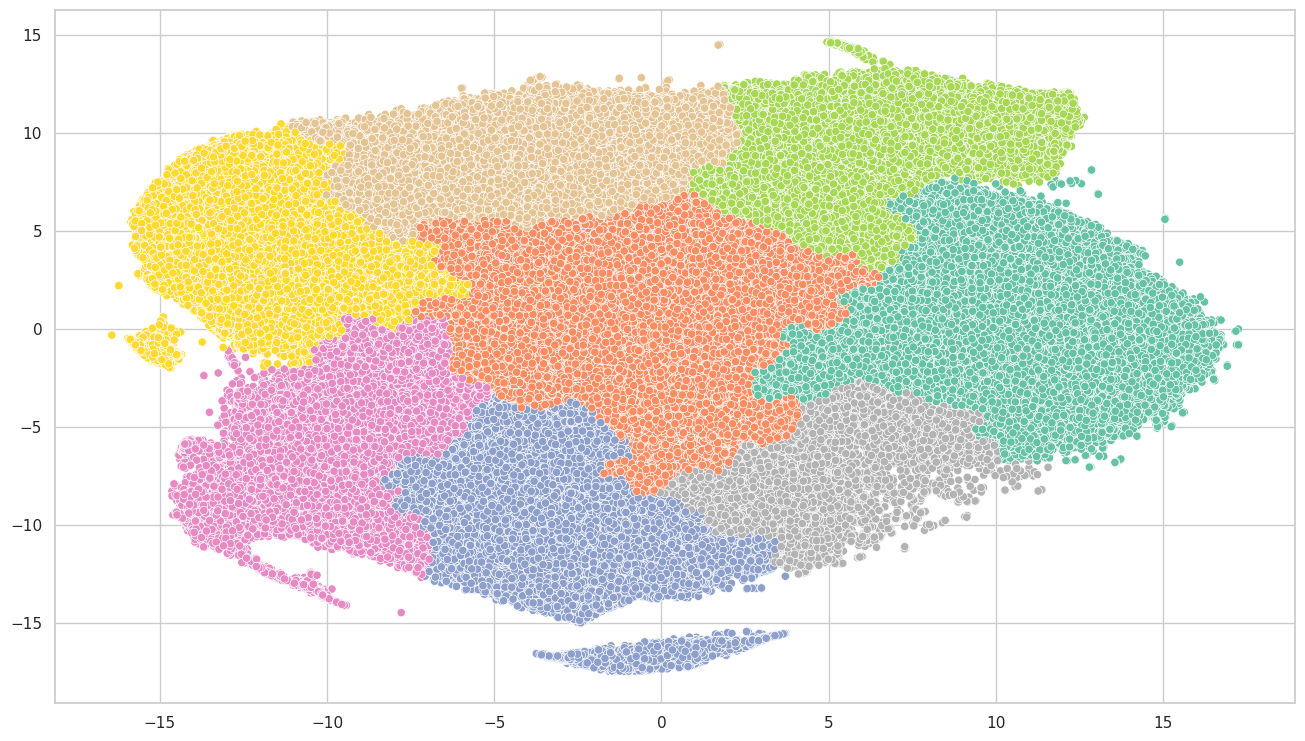

In [25]:
# Show the clusters
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

plt.figure(figsize=(16, 9))
sns.scatterplot(x=embed2d[:, 0], y=embed2d[:, 1], hue=clusters, legend=False, palette="Set2")
plt.show()

In [36]:
# Sample the clusters into one dataframe
train_en["cluster"] = birch.labels_
train_en

,input,label,cluster
0,hide new secretions from the parental units,0,2
1,"contains no wit , only labored gags",0,2
2,that loves its characters and communicates som...,2,2
3,remains utterly satisfied to remain the same t...,0,2
4,on the worst revenge-of-the-nerds clichés the ...,0,2
...,...,...,...
278216,"Very sleek.\n\nIt's still early, but so far th...",2,0
278217,... face mask a few times now and it works gre...,2,4
278218,Five Stars\n\nGreat price. Good quality.,2,5
278219,2016 F150 XLT\n\nFits my 2016 F150 XLT great. ...,2,1


In [38]:
# Sample the clusters (only 1000 samples per cluster) -- this is for demo only
train_en_sampled = train_en.groupby("cluster").apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)
train_en_sampled

,input,label,cluster
0,Love It! Where has this been all my life!!\n\n...,2,0
1,Very Small\n\nI should have read the descripti...,0,0
2,Ehh Get it on sale if you can.\n\nJust alright...,0,0
3,DO NOT BUY! Package busted/leaking and a week ...,0,0
4,It was recommended by others to go larger on t...,0,0
...,...,...,...
7995,Good Product and Customer Support\n\nNice size...,1,7
7996,"second helpings of love , romance , tragedy , ...",2,7
7997,Description very misleading\n\nI bought this d...,0,7
7998,this is the sort of burly action flick where o...,0,7


In [39]:
from transformers import pipeline

pipe = pipeline("translation", model="facebook/nllb-200-3.3B", device="cuda:0", batch_size=64, tgt_lang="tha_Thai", src_lang="eng_Latn")

2023-11-19 08:52:36.462170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 08:52:36.596124: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [40]:
# Translate the samples
to_translate = train_en_sampled["input"].tolist()
translated = pipe(to_translate)

train_en_sampled["input_th"] = translated
train_en_sampled.to_csv("train_enth_sampled.csv", index=False)

Your input_length: 264 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 633 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 281 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 416 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 471 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 204 is bigger than 0.9 * max_length: 200. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)
Your input_length: 729 is bigger than 0.9 * max_length: 200. You

In [41]:
train_en_sampled

,input,label,cluster,input_th
0,Love It! Where has this been all my life!!\n\n...,2,0,{'translation_text': 'รักมัน! ที่นี่เป็นตลอดชี...
1,Very Small\n\nI should have read the descripti...,0,0,{'translation_text': 'ละเอียดมากๆ ผมควรอ่านคํา...
2,Ehh Get it on sale if you can.\n\nJust alright...,0,0,{'translation_text': 'เออ เอาไปขายได้เลย ถ้าทํ...
3,DO NOT BUY! Package busted/leaking and a week ...,0,0,{'translation_text': 'ไม่ต้องซื้อ! แพ็คเกจแตก/...
4,It was recommended by others to go larger on t...,0,0,{'translation_text': 'มันถูกแนะนําโดยคนอื่น ๆ ...
...,...,...,...,...
7995,Good Product and Customer Support\n\nNice size...,1,7,{'translation_text': 'สินค้าที่ดีและการสนับสนุ...
7996,"second helpings of love , romance , tragedy , ...",2,7,{'translation_text': 'ความรักที่สอง ความรักที่...
7997,Description very misleading\n\nI bought this d...,0,7,{'translation_text': 'คําอธิบายที่ผิดมาก ผมซื้...
7998,this is the sort of burly action flick where o...,0,7,{'translation_text': 'นี่คือหนังแอ็คชั่นที่น่า...


In [42]:
train_en_sampled["input_th"] = train_en_sampled["input_th"].apply(lambda x: x["translation_text"])
train_en_sampled

,input,label,cluster,input_th
0,Love It! Where has this been all my life!!\n\n...,2,0,รักมัน! ที่นี่เป็นตลอดชีวิตของฉัน!! รักมันมาก!...
1,Very Small\n\nI should have read the descripti...,0,0,ละเอียดมากๆ ผมควรอ่านคําอธิบายให้ละเอียดกว่านี...
2,Ehh Get it on sale if you can.\n\nJust alright...,0,0,เออ เอาไปขายได้เลย ถ้าทําได้ ก็ได้เลย หนังสือน...
3,DO NOT BUY! Package busted/leaking and a week ...,0,0,ไม่ต้องซื้อ! แพ็คเกจแตก/รั่ว และช้าไปหนึ่งสัปด...
4,It was recommended by others to go larger on t...,0,0,มันถูกแนะนําโดยคนอื่น ๆ ที่จะไปใหญ่กว่าขนาดและ...
...,...,...,...,...
7995,Good Product and Customer Support\n\nNice size...,1,7,สินค้าที่ดีและการสนับสนุนลูกค้า แปรงขนาดสวย แต...
7996,"second helpings of love , romance , tragedy , ...",2,7,ความรักที่สอง ความรักที่สอง ความโศกเศร้า ความต...
7997,Description very misleading\n\nI bought this d...,0,7,คําอธิบายที่ผิดมาก ผมซื้อเครื่องนี้เพราะคําอธิ...
7998,this is the sort of burly action flick where o...,0,7,นี่คือหนังแอ็คชั่นที่น่าตื่นเต้น ที่เหตุบังเอิ...
